In [1]:
from util.log import plot_ts_result, regression_results
from util.model import DQNAgent

import torch
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2


/tmp/ipykernel_1874361/1574615867.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
x_cols = ["EXTN_TPRT", "INNER_HMDT"] 
y_cols = ["INNER_TPRT"]
pred_df_train = pd.read_csv(f"data/pred_{y_cols[0]}_train.csv")
pred_df_test = pd.read_csv(f"data/pred_{y_cols[0]}_test.csv")

In [3]:
class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=4): # data is a batch
        super(GreenhouseTSEnv, self).__init__()

        self.tick = tick
        self.history = data
        self.current_step = 0
        self.nums_data, input_size = data[0].shape
        self.max_steps = self.nums_data
        self.punish = 2

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        self.action_space = spaces.Discrete(3)
        self.actions = {0: self.tick, 1: 0, 2: -self.tick}

    def reset(self):
        self.current_step = 0
        return self.history[0][self.current_step]

    def step(self, action):
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step]
        before_diff = abs(torch.tensor(pred) - answer)
        pred += self.actions[action]
        
        after_diff = abs(torch.tensor(pred) - answer)
        if before_diff < after_diff:
            after_diff *= self.punish
        reward = - after_diff/self.nums_data

        self.current_step += 1
        done = self.current_step >= self.max_steps 
        observation =  None if done else self.history[0][self.current_step]
        

        return observation, reward, done, {"new_pred": pred}

    def step_infer(self, action):
        pred = self.history[0][self.current_step][-1]
        pred += self.actions[action]
        
        self.current_step += 1
        done = self.current_step >= self.max_steps 
        observation =  None if done else self.history[0][self.current_step]
        

        return observation, None, done, {"new_pred": pred}

# Env가 잘 만들어졌는데 실행시키는 코드
batch_size = 4
X = df[x_cols][:100]
X["pred"]  = pred_df_train.iloc[:,-1].values[:100]
X.reset_index(drop=True, inplace=True)
y = pred_df_train["answer"].reset_index(drop=True)[:100]

env = GreenhouseTSEnv([
    X.iloc[:batch_size].to_numpy(),
    y.iloc[:batch_size].to_numpy()
])

observation = env.reset()
for i in range(env.max_steps):
    action = env.action_space.sample()  # Random action for now
    observation, reward, done, _ = env.step(action)
    print(action, observation, reward, done)
    if done:
        print("done")
        break


2 [19.55       64.225      16.57165909] tensor(-6.8661, dtype=torch.float64) False
1 [19.3        64.45       14.91683197] tensor(-2.2946, dtype=torch.float64) False
0 [19.7        65.675      21.93893814] tensor(-1.7208, dtype=torch.float64) False
0 None tensor(-0.1035, dtype=torch.float64) True
done


In [4]:
@dataclass
class Epsilon:
    current: float = 1.0 # start value
    final: float = 0.1
    decay: float = 0.995

# MOVING_AVERAGE_WINDOW = 10
def log_train(episode, episode_rewards, current_epsilon, fname=""):
    print(f"Episode: {episode}, Reward: {episode_rewards[-1].item()}, Epsilon: {current_epsilon}")
    plt.plot(episode_rewards)
    # moving_average = np.convolve(
    #     episode_rewards, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
    # plt.plot(np.arange(MOVING_AVERAGE_WINDOW-1, len(episode_rewards)), 
    #         moving_average, color='red')
    plt.savefig(f"rewards_{fname}.png")

In [5]:
def prepare_data(model_name, pred_df, train_mode=True, window_size=None):
    global df, x_cols, y_cols
    if train_mode:
        X = df[x_cols].iloc[:pred_df.shape[0]]
    else:
        X = df[x_cols][-pred_df.shape[0]:]
    X["pred"] = pred_df[model_name].values
    X.reset_index(drop=True, inplace=True)
    y = pred_df["answer"].reset_index(drop=True)

    if window_size is None:
        window_size = X.shape[0]
        print(X.shape)

    return (X.iloc[:window_size],
            y.iloc[:window_size])
        
def prepare_model():
    state_size = env.observation_space.shape[-1]
    action_size = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DQNAgent(state_size, action_size, device=device)
    return agent

def main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test, tick=4):

    test_X, test_y = prepare_data(model_name, pred_df_test, train_mode=False)
    test_env = GreenhouseTSEnv([test_X.to_numpy(), test_y.to_numpy()], tick=tick)
    result = {
        "explained_variance": [],
        "r2": [],
        "mae": [],
        "mse": [],
        "rmse": [],
    }

    for episode in range(1, max_episodes + 1):
        state = env.reset()
        episode_reward = 0
        for _ in range(env.max_steps): # max_steps_per_episode
            action = agent.select_action(state, epsilons.current)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                break
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            
        epsilons.current = max(epsilons.final, epsilons.current * epsilons.decay)
        episode_rewards.append(episode_reward)
        if episode % 25 == 0:
            log_train(episode, episode_rewards, epsilons.current)
            # y = pred_df["answer"].reset_index(drop=True)
            # main_infer(model_name, pred_df_test, env, agent, ploting=False)
        new_pred_val = [] 
        state = test_env.reset()
        for _ in range(test_env.max_steps):
            action = agent.select_action(state, 0)
            next_state, _, done, info = test_env.step_infer(action)
            new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
            state = next_state
            
            if done:
                break
        for k, v in regression_results(test_y, new_pred_val, print_res=False).items():
            result[k].append(v)
    return result

RNN

(13952, 3)
Episode: 25, Reward: -7.409009982109065, Epsilon: 0.8822202429488013
Episode: 50, Reward: -6.4410579439163245, Epsilon: 0.778312557068642
Episode: 75, Reward: -5.9108601949691755, Epsilon: 0.6866430931872001
Episode: 100, Reward: -5.487767549896245, Epsilon: 0.6057704364907278
Episode: 125, Reward: -5.047324920368198, Epsilon: 0.5344229416520513
Episode: 150, Reward: -4.792089036083222, Epsilon: 0.47147873742168567
Episode: 175, Reward: -4.666194426059726, Epsilon: 0.4159480862733536
Episode: 200, Reward: -4.28409369621277, Epsilon: 0.3669578217261671
Episode: 225, Reward: -3.9665399273872377, Epsilon: 0.3237376186352221
Episode: 250, Reward: -3.7528881148338304, Epsilon: 0.285607880564032
Episode: 275, Reward: -3.8141471313476583, Epsilon: 0.2519690537792925
Episode: 300, Reward: -3.5546684999465996, Epsilon: 0.22229219984074702
Episode: 325, Reward: -3.485936714553834, Epsilon: 0.19611067854912728
Episode: 350, Reward: -3.3356645909309384, Epsilon: 0.1730128104744653


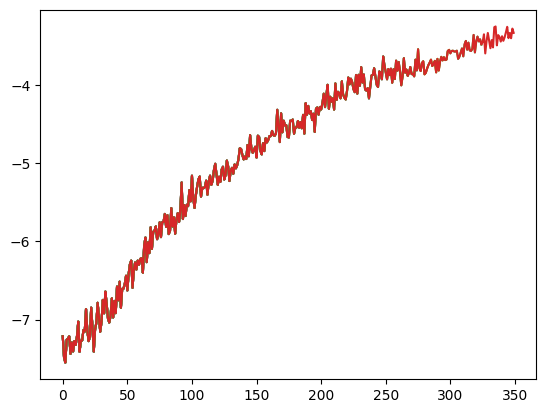

In [7]:
model_name = "RNN"
tick = 4
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

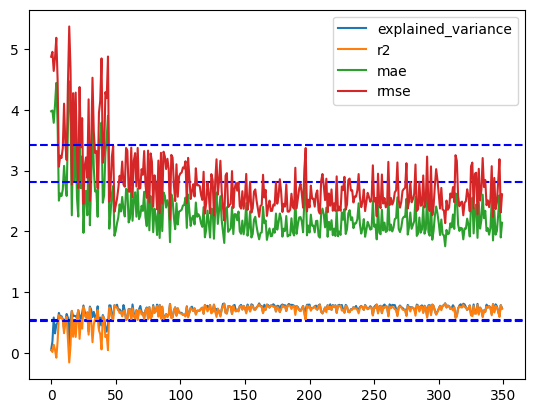

In [8]:
before = {
    "explained_variance":  0.5485,
    "r2":  0.5337,
    "mae":  2.808,
    "mse":  11.6432,
    "rmse":  3.4122,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

LSTM

(13952, 3)
Episode: 25, Reward: -7.197761799144739, Epsilon: 0.8822202429488013
Episode: 50, Reward: -6.8633113027572765, Epsilon: 0.778312557068642
Episode: 75, Reward: -6.2804382036209, Epsilon: 0.6866430931872001
Episode: 100, Reward: -5.82788529205321, Epsilon: 0.6057704364907278
Episode: 125, Reward: -5.2964575906753515, Epsilon: 0.5344229416520513
Episode: 150, Reward: -4.959397704410547, Epsilon: 0.47147873742168567
Episode: 175, Reward: -4.942315564918514, Epsilon: 0.4159480862733536
Episode: 200, Reward: -4.668670712280267, Epsilon: 0.3669578217261671
Episode: 225, Reward: -4.359306829929353, Epsilon: 0.3237376186352221
Episode: 250, Reward: -4.278878871726989, Epsilon: 0.285607880564032
Episode: 275, Reward: -4.211739306449883, Epsilon: 0.2519690537792925
Episode: 300, Reward: -4.101822480678553, Epsilon: 0.22229219984074702
Episode: 325, Reward: -3.844658991336821, Epsilon: 0.19611067854912728
Episode: 350, Reward: -3.662070718097686, Epsilon: 0.1730128104744653
Episode: 375

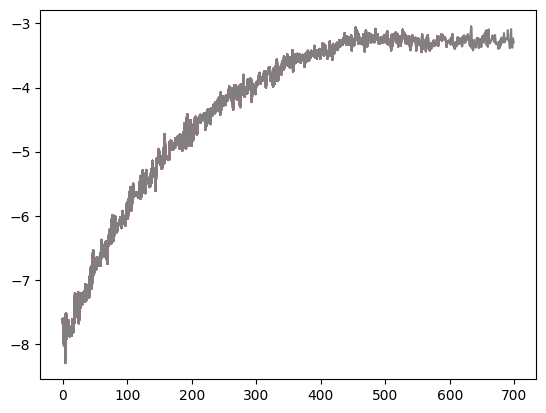

In [11]:
model_name = "LSTM"
tick = 4
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 700
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

In [ ]:
# tick = 4, max_episodes = 700
before = {
    "explained_variance":  0.8258,
    "r2":  0.7866,
    "mae":  1.9452,
    "mse":  5.3277,
    "rmse":  2.3082,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

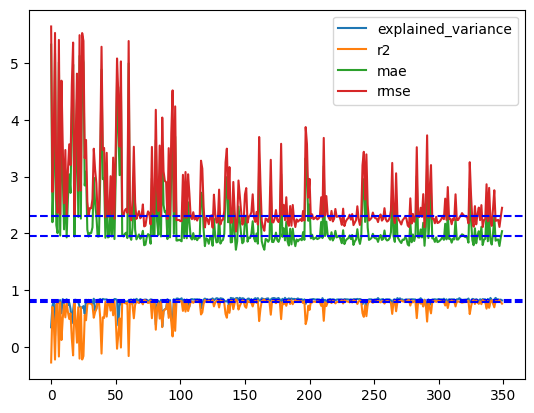

In [10]:
# tick = 4, max_episodes = 350
before = {
    "explained_variance":  0.8258,
    "r2":  0.7866,
    "mae":  1.9452,
    "mse":  5.3277,
    "rmse":  2.3082,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

(13952, 3)
Episode: 25, Reward: -6.382866894245138, Epsilon: 0.8822202429488013
Episode: 50, Reward: -5.918869502258299, Epsilon: 0.778312557068642
Episode: 75, Reward: -5.5711328705787535, Epsilon: 0.6866430931872001
Episode: 100, Reward: -5.208618427753441, Epsilon: 0.6057704364907278
Episode: 125, Reward: -5.025333939075465, Epsilon: 0.5344229416520513
Episode: 150, Reward: -4.753845002841939, Epsilon: 0.47147873742168567
Episode: 175, Reward: -4.717883277797689, Epsilon: 0.4159480862733536
Episode: 200, Reward: -4.502438438796988, Epsilon: 0.3669578217261671
Episode: 225, Reward: -4.449916900062557, Epsilon: 0.3237376186352221
Episode: 250, Reward: -4.246726802635191, Epsilon: 0.285607880564032
Episode: 275, Reward: -4.128793022441863, Epsilon: 0.2519690537792925
Episode: 300, Reward: -3.9512672320365883, Epsilon: 0.22229219984074702
Episode: 325, Reward: -3.9996052353858973, Epsilon: 0.19611067854912728
Episode: 350, Reward: -3.821670619106289, Epsilon: 0.1730128104744653


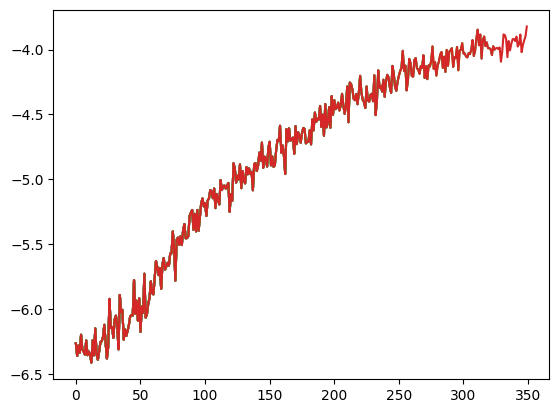

In [19]:
model_name = "LSTM"
tick = 3
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

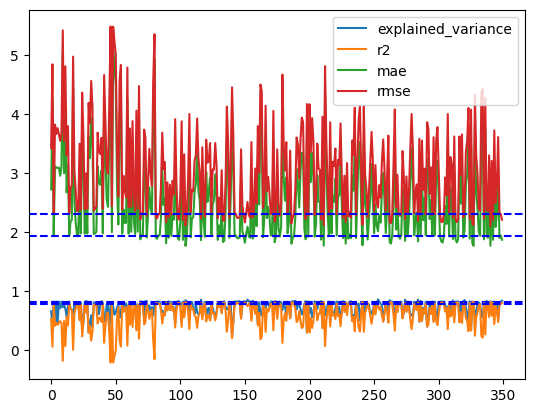

In [20]:
before = {
    "explained_variance":  0.8258,
    "r2":  0.7866,
    "mae":  1.9452,
    "mse":  5.3277,
    "rmse":  2.3082,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

(13952, 3)
Episode: 25, Reward: -7.973486084365849, Epsilon: 0.8822202429488013
Episode: 50, Reward: -7.283587661170966, Epsilon: 0.778312557068642
Episode: 75, Reward: -6.8504867885589595, Epsilon: 0.6866430931872001
Episode: 100, Reward: -6.493158029174812, Epsilon: 0.6057704364907278
Episode: 125, Reward: -5.680863970661159, Epsilon: 0.5344229416520513
Episode: 150, Reward: -5.45351348047257, Epsilon: 0.47147873742168567
Episode: 175, Reward: -5.257641985225674, Epsilon: 0.4159480862733536
Episode: 200, Reward: -4.904000140476227, Epsilon: 0.3669578217261671
Episode: 225, Reward: -4.401431306266785, Epsilon: 0.3237376186352221
Episode: 250, Reward: -4.417207415103917, Epsilon: 0.285607880564032
Episode: 275, Reward: -4.124382040500644, Epsilon: 0.2519690537792925
Episode: 300, Reward: -3.970748037624366, Epsilon: 0.22229219984074702
Episode: 325, Reward: -3.898711068248751, Epsilon: 0.19611067854912728
Episode: 350, Reward: -3.571079752254485, Epsilon: 0.1730128104744653


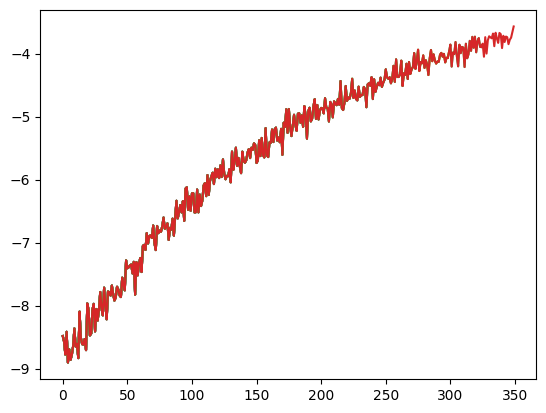

In [22]:
model_name = "LSTM"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=5)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

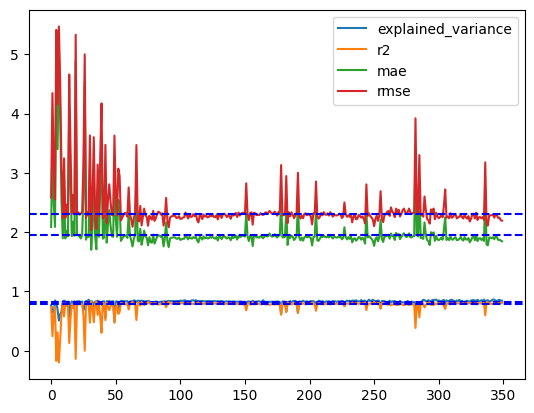

In [23]:
before = {
    "explained_variance":  0.8258,
    "r2":  0.7866,
    "mae":  1.9452,
    "mse":  5.3277,
    "rmse":  2.3082,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

Transformer

(13952, 3)
Episode: 25, Reward: -8.321680605697637, Epsilon: 0.8822202429488013
Episode: 50, Reward: -8.13384876556396, Epsilon: 0.778312557068642
Episode: 75, Reward: -7.397261539936054, Epsilon: 0.6866430931872001
Episode: 100, Reward: -6.72271047172546, Epsilon: 0.6057704364907278
Episode: 125, Reward: -6.148819279575332, Epsilon: 0.5344229416520513
Episode: 150, Reward: -5.903690112304687, Epsilon: 0.47147873742168567
Episode: 175, Reward: -5.415240235710142, Epsilon: 0.4159480862733536
Episode: 200, Reward: -5.317247721576691, Epsilon: 0.3669578217261671
Episode: 225, Reward: -4.980642541122439, Epsilon: 0.3237376186352221
Episode: 250, Reward: -4.827137052631378, Epsilon: 0.285607880564032
Episode: 275, Reward: -4.529467105674745, Epsilon: 0.2519690537792925
Episode: 300, Reward: -4.497586522197729, Epsilon: 0.22229219984074702
Episode: 325, Reward: -4.279113894748682, Epsilon: 0.19611067854912728
Episode: 350, Reward: -4.159966942977909, Epsilon: 0.1730128104744653


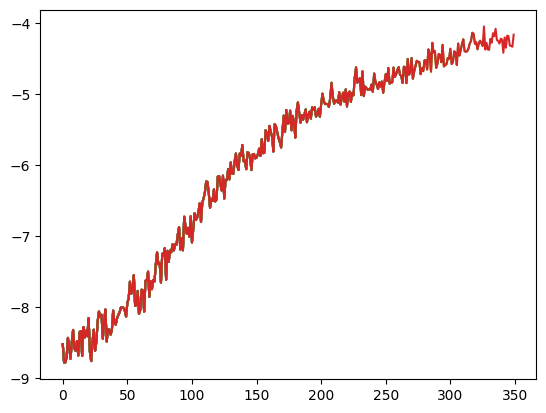

In [12]:
model_name = "Transformer"
tick = 4
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

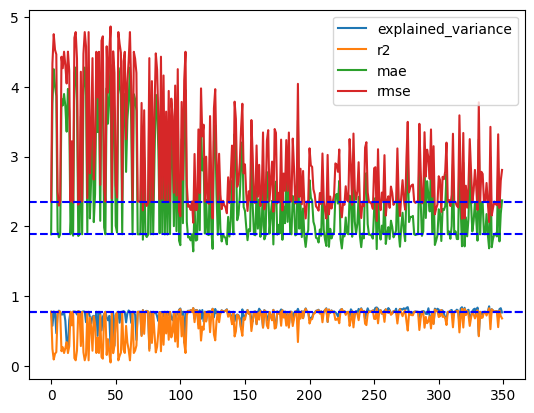

In [13]:
before = {
    "explained_variance":  0.7786,
    "r2":  0.7776,
    "mae":  1.8881,
    "mse":  5.5545,
    "rmse":  2.3568
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  
plt.legend()

In [ ]:
model_name = "Transformer"
tick=3
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)



In [ ]:
before = {
    "explained_variance":  0.7786,
    "r2":  0.7776,
    "mae":  1.8881,
    "mse":  5.5545,
    "rmse":  2.3568
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

XGBoost

(13952, 3)
Episode: 25, Reward: -5.521143143500006, Epsilon: 0.8822202429488013
Episode: 50, Reward: -5.106312019500004, Epsilon: 0.778312557068642
Episode: 75, Reward: -4.284962082999998, Epsilon: 0.6866430931872001
Episode: 100, Reward: -3.9018391269999997, Epsilon: 0.6057704364907278
Episode: 125, Reward: -3.4910308230000076, Epsilon: 0.5344229416520513
Episode: 150, Reward: -3.1854003610000037, Epsilon: 0.47147873742168567
Episode: 175, Reward: -3.0754329225000054, Epsilon: 0.4159480862733536
Episode: 200, Reward: -2.826620411500005, Epsilon: 0.3669578217261671
Episode: 225, Reward: -2.5303541635000038, Epsilon: 0.3237376186352221
Episode: 250, Reward: -2.3308292890000017, Epsilon: 0.285607880564032
Episode: 275, Reward: -2.2063994895000003, Epsilon: 0.2519690537792925
Episode: 300, Reward: -2.1246476790000015, Epsilon: 0.22229219984074702
Episode: 325, Reward: -1.9434536769999964, Epsilon: 0.19611067854912728
Episode: 350, Reward: -1.9386923199999966, Epsilon: 0.1730128104744653


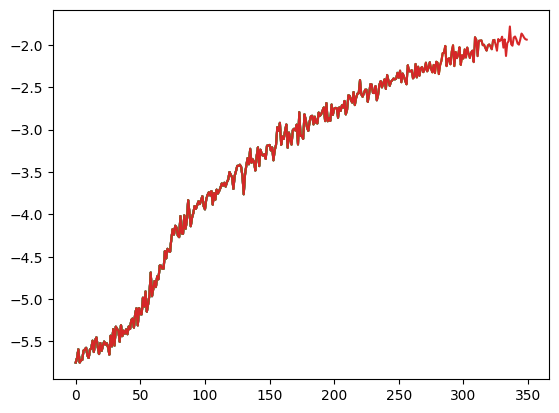

In [14]:
model_name = "XGBoost"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=4)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

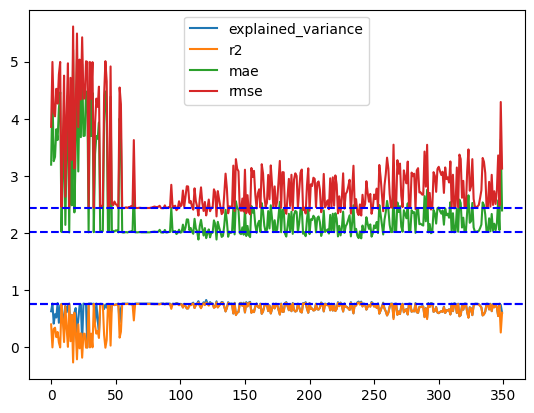

In [15]:
before = {
    "explained_variance":  0.7674,
    "r2":  0.7618,
    "mae":  2.013,
    "mse":  5.9477,
    "rmse":  2.4388
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()